---


| | |
|---|---|
| **Autor notatnika** | Damian Sałkowski |
| **Wersja** | 1.0 |
| **Wydawca** | [sensai.academy](https://sensai.academy/) |
| **Lekcja** | AI Crawling |
| **Tydzień programu** | 2 |
| **Pytania? Napisz na discord. 📩 ** | **damian_17365** |


---


# AI Crawling


W tym notebooku pokażę Ci w jaki sposób wykorzytać narzędzie Crawl4AI do crawlowania.

#**❗️ Ważne: Zanim zaczniesz, zrób kopię tego notatnika!**

Aby móc edytować, uruchamiać kod i zapisywać zmiany, musisz pracować na własnej kopii tego pliku.

**Jak skopiować notatnik w Google Colab:**
1.  Przejdź do menu na górze strony.
2.  Kliknij **`Plik`**.
3.  Z rozwijanego menu wybierz opcję **`Zapisz kopię na Dysku`**.
4.  Nowa karta otworzy się z Twoją osobistą kopią notatnika (nazwa pliku będzie zaczynać się od "Kopia notatnika...").
5.  **Wszystkie dalsze kroki wykonuj w tej nowo otwartej kopii.**

## Instalacja wymaganych bibliotek



In [ ]:
!pip install crawl4ai
!pip install nest-asyncio

Importowanie bibliotek

In [ ]:
import asyncio
import nest_asyncio
from crawl4ai import AsyncWebCrawler
from crawl4ai.extraction_strategy import JsonCssExtractionStrategy, LLMExtractionStrategy
import json
import time
from pydantic import BaseModel, Field

nest_asyncio.apply()

In [ ]:
#@title Wprowadź klucze API (z Colab Secrets)

# Ważne: Klucze API najlepiej przechowywać w bezpieczny sposób, np. w Google Colab Secrets.
# Po lewej stronie interfejsu Colab, znajdź ikonę "klucza" (Sekrety), kliknij ją, a następnie
# dodaj nowe sekrety o nazwach zgodnych z poniższymi zmiennymi (np. SECRET_OPENAI_API_KEY).
# Wartości kluczy skopiuj z panelu dostawcy usługi.
# Ta komórka pobierze klucze z Colab Secrets i ustawi je jako zmienne środowiskowe.
# Jeśli nie masz klucza dla danej usługi, możesz pominąć dodawanie go do sekretów i jego pole zostanie puste.

import os
from google.colab import userdata

#@markdown Klucz OpenAI: Znajdź na https://platform.openai.com/account/api-keys
OPENAI_API_KEY = userdata.get('SECRET_OPENAI_API_KEY') #@param {type:"string"}

Now, let's import the necessary libraries:

# 3. Zaawansowane Crawlowanie z `AsyncWebCrawler` i Konfiguracją ⚙️

Ta komórka pokazuje, jak używać klasy `AsyncWebCrawler` z biblioteki `crawl4ai` wraz z dodatkową konfiguracją, aby precyzyjniej kontrolować proces pobierania danych ze strony internetowej. W szczególności, wykorzystujemy `CrawlerRunConfig` do zarządzania ustawieniami dla pojedynczego uruchomienia crawlera, w tym trybem cache'owania.

**Co robi ten skrypt?**
1.  **Importy i konfiguracja `asyncio`:** Importuje niezbędne klasy (`AsyncWebCrawler`, `CrawlerRunConfig`, `CacheMode`) oraz bibliotekę `asyncio`. Wywołanie `nest_asyncio.apply()` jest często potrzebne w środowiskach takich jak Jupyter/Colab, aby umożliwić zagnieżdżanie pętli zdarzeń `asyncio`, co może być wymagane przez niektóre biblioteki asynchroniczne.
2.  **Definicja parametrów:** Używa interaktywnego pola (`#@param`) do ustawienia adresu URL (`url_to_crawl`), który ma być przetworzony.
3.  **Definicja funkcji asynchronicznej:** Tworzy funkcję `advanced_async_crawl`, która zawiera logikę crawlowania.
4.  **Konfiguracja uruchomienia:** Wewnątrz funkcji tworzony jest obiekt `CrawlerRunConfig`. Ustawiany jest `cache_mode=CacheMode.BYPASS`, co oznacza, że crawler **nie będzie** korzystał z żadnego zapisanego wcześniej cache'u dla tego konkretnego adresu URL i pobierze stronę "na świeżo". Inne opcje `CacheMode` mogłyby pozwolić na szybsze odczyty, jeśli strona była już wcześniej pobrana.
5.  **Inicjalizacja i uruchomienie crawlera:** Tworzony jest kontekst `async with AsyncWebCrawler()`, który zarządza cyklem życia crawlera. Następnie wywoływana jest metoda `crawler.arun()` z podanym URL-em oraz obiektem konfiguracji (`config=crawler_run_config`).
6.  **Dostęp do wyników:** Po pobraniu danych, skrypt uzyskuje dostęp do przetworzonej treści w formacie Markdown V2 poprzez `result.markdown_v2.raw_markdown`.
7.  **Wyświetlanie:** Wyświetlana jest długość pobranej treści oraz jej początkowy fragment (pierwsze 500 znaków), z zamianą znaków nowej linii na " -- " dla lepszej czytelności w jednej linii. Dodano również podstawową obsługę błędów.
8.  **Wywołanie funkcji:** Funkcja asynchroniczna jest uruchamiana za pomocą `await` na najwyższym poziomie, co jest standardem w Colab.


**Eksperymentuj:** Zmień `url_to_crawl` na inny adres. Sprawdź dokumentację `crawl4ai`, aby zobaczyć inne dostępne opcje dla `CrawlerRunConfig` i `CacheMode`, i przetestuj ich działanie.

In [ ]:
import asyncio
import nest_asyncio
from crawl4ai import AsyncWebCrawler, CacheMode, CrawlerRunConfig # Importujemy potrzebne klasy
import time

# Zastosowanie nest_asyncio dla kompatybilności w środowiskach typu Jupyter/Colab.
nest_asyncio.apply()

# --- Parametry Interaktywne ---
url_to_crawl = "https://www.sensai.academy/" #@param {type:"string"} # Adres URL strony do pobrania

# --- Logika Crawlowania ---

async def robust_async_crawl(target_url: str):
    """
    Funkcja wykonuje crawlowanie i sprawdza różne pola wynikowe w celu znalezienia treści.
    """
    print(f"Rozpoczynanie crawlowania strony: {target_url}")
    print("Tryb cache: BYPASS (zawsze pobieraj świeżą wersję)")

    # Konfiguracja uruchomienia crawlera - jawne ustawienie CacheMode.BYPASS
    crawler_run_config = CrawlerRunConfig(cache_mode=CacheMode.BYPASS)
    print("Utworzono konfigurację uruchomienia (cache bypass).")

    try:
        # Użycie AsyncWebCrawler jako menedżera kontekstu
        async with AsyncWebCrawler(verbose=True) as crawler:
            print("Crawler zainicjalizowany. Rozpoczynanie pobierania (arun)...")
            start_time = time.time() # Mierzymy czas

            # Uruchomienie crawlera
            result_container = await crawler.arun(
                url=target_url,
                config=crawler_run_config
            )

            end_time = time.time()
            duration = end_time - start_time
            print(f"Pobieranie zakończone w {duration:.2f} sek.")

            # --- Odporna logika dostępu do wyniku ---
            if result_container and len(result_container) > 0:
                crawl_result = result_container[0]
                extracted_content = None
                content_field_name = "Nie znaleziono"

                # Sprawdzanie pól w preferowanej kolejności
                if hasattr(crawl_result, 'markdown_v2') and \
                   crawl_result.markdown_v2 and \
                   hasattr(crawl_result.markdown_v2, 'raw_markdown') and \
                   crawl_result.markdown_v2.raw_markdown:
                    extracted_content = crawl_result.markdown_v2.raw_markdown
                    content_field_name = "markdown_v2.raw_markdown"

                elif hasattr(crawl_result, 'markdown') and crawl_result.markdown:
                    extracted_content = crawl_result.markdown
                    content_field_name = "markdown"

                elif hasattr(crawl_result, 'cleaned_html') and crawl_result.cleaned_html:
                    extracted_content = crawl_result.cleaned_html
                    content_field_name = "cleaned_html"

                elif hasattr(crawl_result, 'text') and crawl_result.text: # Dodatkowe sprawdzenie pola 'text'
                    extracted_content = crawl_result.text
                    content_field_name = "text"

                # Wyświetlenie znalezionej treści lub komunikatu o błędzie
                if extracted_content:
                    content_length = len(extracted_content)
                    print(f"\n✅ Pomyślnie pobrano treść z pola: '{content_field_name}' (długość: {content_length} znaków).")

                    snippet = extracted_content[:500].replace("\n", " -- ")
                    print(f"\n--- Początek treści ({content_field_name}, fragment) ---")
                    print(snippet)
                    print(f"--- Koniec fragmentu treści ({content_field_name}) ---")
                else:
                    # Informacja, jeśli żadne z oczekiwanych pól nie zawierało treści
                    print("\n❌ Nie znaleziono użytecznej treści w polach: 'markdown_v2.raw_markdown', 'markdown', 'cleaned_html', 'text'.")
                    if hasattr(crawl_result, 'html') and crawl_result.html:
                         print("   Dostępny jest surowy HTML w polu 'html'.")
                    else:
                         print("   Nie znaleziono również surowego HTML.")
                    print(f"   Sprawdź dostępne atrybuty w CrawlResult: {dir(crawl_result)}")

            else:
                print("\n❌ Crawler nie zwrócił żadnych wyników (CrawlResultContainer jest pusty).")
                print(f"   Otrzymany kontener: {result_container}")

    except Exception as e:
        # Ogólna obsługa błędów
        print(f"\n❌ Wystąpił błąd podczas crawlowania strony {target_url}:")
        print(f"   Typ błędu: {type(e).__name__}")
        print(f"   Szczegóły: {e}")
        import traceback
        traceback.print_exc()

# --- Uruchomienie Zadania ---
print(f"--- Rozpoczęcie zadania dla URL: {url_to_crawl} ---")

# Uruchomienie funkcji asynchronicznej
await robust_async_crawl(target_url=url_to_crawl)

print("\n--- Zakończono zadanie ---")

--- Rozpoczęcie zadania dla URL: https://www.sensai.academy/ ---
Rozpoczynanie crawlowania strony: https://www.sensai.academy/
Tryb cache: BYPASS (zawsze pobieraj świeżą wersję)
Utworzono konfigurację uruchomienia (cache bypass).
[INIT].... → Crawl4AI 0.6.2
Crawler zainicjalizowany. Rozpoczynanie pobierania (arun)...
[FETCH]... ↓ https://www.sensai.academy/                                                                          | ✓ | ⏱: 4.82s
[SCRAPE].. ◆ https://www.sensai.academy/                                                                          | ✓ | ⏱: 0.78s
[COMPLETE] ● https://www.sensai.academy/                                                                          | ✓ | ⏱: 5.63s
Pobieranie zakończone w 5.63 sek.

✅ Pomyślnie pobrano treść z pola: 'markdown' (długość: 53166 znaków).

--- Początek treści (markdown, fragment) ---
[Śpiesz się! Startujemy 12 majaCena wzrośnie za:2 dnii11:04:59](https://www.sensai.academy/old-home-2) -- [![SENSAI logo](https://cdn.prod.webs

💡 By default, **Crawl4AI** caches the result of every URL, so the next time you call it, you’ll get an instant result. But if you want to bypass the cache, just set `bypass_cache=True`.

### Extracting Structured Data with OpenAI

Note: You'll need to set your OpenAI API key as an environment variable for this example to work.

[LOG] 🚀 Crawl4AI 0.3.731
[LOG] 🌤️  Warming up the AsyncWebCrawler
[LOG] 🌞 AsyncWebCrawler is ready to crawl
[LOG] 🕸️ Crawling https://www.senuto.com/en/pricing/ using AsyncPlaywrightCrawlerStrategy...
[LOG] ✅ Crawled https://www.senuto.com/en/pricing/ successfully!
[LOG] 🚀 Crawling done for https://www.senuto.com/en/pricing/, success: True, time taken: 4.97 seconds
[LOG] 🚀 Content extracted for https://www.senuto.com/en/pricing/, success: True, time taken: 2.97 seconds
[LOG] 🔥 Extracting semantic blocks for https://www.senuto.com/en/pricing/, Strategy: AsyncWebCrawler
[LOG] Call LLM for https://www.senuto.com/en/pricing/ - block index: 0
[LOG] Call LLM for https://www.senuto.com/en/pricing/ - block index: 1
[LOG] Call LLM for https://www.senuto.com/en/pricing/ - block index: 2
[LOG] Extracted 0 blocks from URL: https://www.senuto.com/en/pricing/ block index: 0
[LOG] Extracted 2 blocks from URL: https://www.senuto.com/en/pricing/ block index: 1
[LOG] Extracted 16 blocks from URL: https:
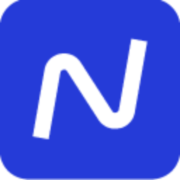

ValueError: Extracted content is not in the expected format (list of dictionaries)

In [ ]:
import os as os
import pandas as pd
os.environ["OPENAI_API_KEY"] = ""

class SenutoPricing(BaseModel):
    package_name: str = Field(..., description="Name of the Senuto package.")
    price: str = Field(..., description="Price of the Senuto package.")

async def extract_senuto_pricing():
    async with AsyncWebCrawler(verbose=True) as crawler:
        try:
            result = await crawler.arun(
                url='https://www.senuto.com/en/pricing/',
                word_count_threshold=1,
                extraction_strategy=LLMExtractionStrategy(
                    provider="openai/gpt-4o", api_token=os.environ["OPENAI_API_KEY"],
                    schema=SenutoPricing.schema(),
                    extraction_type="schema",
                    instruction="""From the crawled content, extract all packages and their pricing.
                    Do not miss any packages in the entire content. One extracted package JSON format should look like this:
                    {"package_name": "Basic", "price": "$99", "period: "Month/Year", "Type": "Package/Addon", Payment: "Yearly/Monthly"}"""
                ),
                bypass_cache=True,
            )

            print("Raw result:", result)
            print("Type of result:", type(result))
            print("Content of result:", result.extracted_content if hasattr(result, 'extracted_content') else "No extracted_content attribute")

            if not hasattr(result, 'extracted_content') or not result.extracted_content:
                raise ValueError("No extracted content found in the result")

            # Ensure the extracted content is a list of dictionaries
            if not isinstance(result.extracted_content, list) or not all(isinstance(item, dict) for item in result.extracted_content):
                raise ValueError("Extracted content is not in the expected format (list of dictionaries)")

            # Convert extracted content to a pandas DataFrame
            df = pd.DataFrame(result.extracted_content)

            # Display the results
            print(f"Extracted {len(df)} Senuto packages:")
            display(df)

            # Optional: Create a bar chart of prices
            try:
                # Convert price strings to numeric values (assuming all prices are in USD)
                df['numeric_price'] = df['price'].str.extract('(\d+)').astype(float)

                # Create and display a bar chart
                ax = df.plot(kind='bar', x='package_name', y='numeric_price', figsize=(10, 6), legend=False)
                ax.set_ylabel('Price (USD)')
                ax.set_title('Senuto Package Pricing')
                for i, v in enumerate(df['numeric_price']):
                    ax.text(i, v, f'${v}', ha='center', va='bottom')
                display(ax.figure)
            except Exception as e:
                print(f"Could not create chart due to error: {e}")

        except Exception as e:
            print(f"An error occurred during extraction: {e}")
            raise

# Funkcja główna do uruchomienia asynchronicznego kodu
async def main():
    await extract_senuto_pricing()

# Uruchomienie kodu asynchronicznego
if __name__ == "__main__":
    asyncio.run(main())